DATASETS

1. World Bank Open Data - Forest coverage (API)
2. UN Data - Population by sex and urban/rural residence between 2000 - 2020 (csv)
3. Food and Agriculture Organization of the United Nations (FAO) - FAOSTAT (csv)

In [90]:
import numpy as np
import pandas as pd

import wbdata
import datetime 

import pycountry
import pycountry_convert as pc

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


import re 
regex_pattern = re.compile(r'\s\((.*?)\)|(\s?,.*)')



Installed the wbdata library to access the World Bank Open Data API 

In [2]:
pip install wbdata

Note: you may need to restart the kernel to use updated packages.


Dataset #1 | Forest coverage

In [3]:
# Set the indicator code for forest coverage
indicator_code = 'AG.LND.FRST.ZS'

# Set the start and end year for the data
start_year = 2000
end_year = 2020

# Set the countries to retrieve data for
countries = ['ITA', 'DEU', 'JPN']

# Retrieve the data
start_date = datetime.datetime(start_year, 1, 1)
end_date = datetime.datetime(end_year, 12, 31)

forest_data = wbdata.get_data(indicator_code, country=countries, data_date=(start_date, end_date))

# Convert the data to a pandas DataFrame
df = pd.DataFrame(forest_data)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   indicator        63 non-null     object 
 1   country          63 non-null     object 
 2   countryiso3code  63 non-null     object 
 3   date             63 non-null     object 
 4   value            63 non-null     float64
 5   unit             63 non-null     object 
 6   obs_status       63 non-null     object 
 7   decimal          63 non-null     int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 4.1+ KB


,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
0,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'DE', 'value': 'Germany'}",DEU,2020,32.682676,,,1
1,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'DE', 'value': 'Germany'}",DEU,2019,32.682676,,,1
2,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'DE', 'value': 'Germany'}",DEU,2018,32.683611,,,1
3,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'DE', 'value': 'Germany'}",DEU,2017,32.684546,,,1
4,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'DE', 'value': 'Germany'}",DEU,2016,32.685482,,,1


In [4]:
# Calculate the average forest coverage for each country
avg_forest_coverage = df.groupby('countryiso3code')['value'].mean()

# Print the average forest coverage for each country
print('Average forest coverage by country:')
print(avg_forest_coverage)

Average forest coverage by country:
countryiso3code
DEU    32.669641
ITA    30.422328
JPN    68.400941
Name: value, dtype: float64


In [5]:
# Determine which country has the highest and lowest forest coverage
max_coverage = df.loc[df['value'].idxmax()]
min_coverage = df.loc[df['value'].idxmin()]

# Print the country with the highest and lowest forest coverage
print(f'The country with the highest forest coverage is {max_coverage["country"]} with a coverage of {max_coverage["value"]:.2f}%.')
print(f'The country with the lowest forest coverage is {min_coverage["country"]} with a coverage of {min_coverage["value"]:.2f}%.')

# Determine if any country has seen significant increases or decreases in forest coverage during the specified time period
for country in countries:
    country_data = df.loc[df['countryiso3code'] == country]
    initial_coverage = country_data.loc[country_data['date'] == str(start_year)]['value'].values[0]
    final_coverage = country_data.loc[country_data['date'] == str(end_year)]['value'].values[0]
    change = final_coverage - initial_coverage
    if abs(change) > 5:
        if change > 0:
            print(f'{country} has seen a significant increase in forest coverage of {change:.2f}% between {start_year} and {end_year}.')
        else:
            print(f'{country} has seen a significant decrease in forest coverage of {change:.2f}% between {start_year} and {end_year}.')

The country with the highest forest coverage is {'id': 'JP', 'value': 'Japan'} with a coverage of 68.49%.
The country with the lowest forest coverage is {'id': 'IT', 'value': 'Italy'} with a coverage of 28.30%.


In [6]:
# Retrieve the global forest coverage data for the specified time period
global_forest_data = wbdata.get_data(indicator_code,  data_date=(start_date, end_date))

global_forest_df = pd.DataFrame(global_forest_data)
global_forest_df.head()


,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
0,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2020,30.174186,,,1
1,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2019,30.391558,,,1
2,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2018,30.611444,,,1
3,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2017,30.824248,,,1
4,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2016,31.039613,,,1


In [7]:
global_forest_df.tail()

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal
5581,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZW', 'value': 'Zimbabwe'}",ZWE,2004,46.999354,,,1
5582,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZW', 'value': 'Zimbabwe'}",ZWE,2003,47.118444,,,1
5583,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZW', 'value': 'Zimbabwe'}",ZWE,2002,47.237534,,,1
5584,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZW', 'value': 'Zimbabwe'}",ZWE,2001,47.356624,,,1
5585,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZW', 'value': 'Zimbabwe'}",ZWE,2000,47.475714,,,1


In [8]:
global_forest_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
value,5445.0,32.209728,23.101674,0.0,12.413502,30.583894,46.754581,98.33891
decimal,5586.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.00000


In [9]:
# Calculate the average global forest coverage 
global_avg_forest_coverage = df['value'].mean()
print(global_avg_forest_coverage)

# Compare the average forest coverage in the selected countries to the global average
if avg_forest_coverage.mean() > global_avg_forest_coverage:
    print('The selected countries have higher than average forest coverage compared to the global average.')
elif avg_forest_coverage.mean() < global_avg_forest_coverage:
    print('The selected countries have lower than average forest coverage compared to the global average.')
else:
    print('The selected countries have average forest coverage compared to the global average.')

43.83096996881229
The selected countries have average forest coverage compared to the global average.


Country names

In [10]:
pip install pycountry pycountry_convert

Cleaning country names

In [11]:
def clean_country_name (name):
    if name is None:
        return name
    return re.sub(regex_pattern, '', name)

Assigning countries to continents

In [12]:
def country_to_continent (country_alpha2):        
    continent_code = pc.country_alpha2_to_continent_code (country_alpha2)    
    continent_name = pc.convert_continent_code_to_continent_name(continent_code)
    return continent_name

def country_name_to_continent (country_name):        
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)    
        continent_name = country_to_continent(country_code)
        return continent_name
    except:        
        pass
    

# Create a lookup table mapping country names to continents
country_name_to_continent = {}
for country in pycountry.countries:  
    try:
        continent = country_to_continent(country.alpha_2)        
        country_name_to_continent[clean_country_name(country.name)]= continent         
    except:
        pass
print(country_name_to_continent)

{'Aruba': 'North America', 'Afghanistan': 'Asia', 'Angola': 'Africa', 'Anguilla': 'North America', 'Åland Islands': 'Europe', 'Albania': 'Europe', 'Andorra': 'Europe', 'United Arab Emirates': 'Asia', 'Argentina': 'South America', 'Armenia': 'Asia', 'American Samoa': 'Oceania', 'Antigua and Barbuda': 'North America', 'Australia': 'Oceania', 'Austria': 'Europe', 'Azerbaijan': 'Asia', 'Burundi': 'Africa', 'Belgium': 'Europe', 'Benin': 'Africa', 'Bonaire': 'North America', 'Burkina Faso': 'Africa', 'Bangladesh': 'Asia', 'Bulgaria': 'Europe', 'Bahrain': 'Asia', 'Bahamas': 'North America', 'Bosnia and Herzegovina': 'Europe', 'Saint Barthélemy': 'North America', 'Belarus': 'Europe', 'Belize': 'North America', 'Bermuda': 'North America', 'Bolivia': 'South America', 'Brazil': 'South America', 'Barbados': 'North America', 'Brunei Darussalam': 'Asia', 'Bhutan': 'Asia', 'Bouvet Island': 'Antarctica', 'Botswana': 'Africa', 'Central African Republic': 'Africa', 'Canada': 'North America', 'Cocos Isla

In [13]:
def country_code_to_name (row):
    code = row ['countryiso3code']
    try:
        return pycountry.countries.get(alpha_3=code).name
    except:
        pass

global_forest_df['country_name']=global_forest_df.apply(lambda row:country_code_to_name(row), axis=1)
global_forest_df.head()

,indicator,country,countryiso3code,date,value,unit,obs_status,decimal,country_name
0,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2020,30.174186,,,1,None
1,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2019,30.391558,,,1,None
2,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2018,30.611444,,,1,None
3,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2017,30.824248,,,1,None
4,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2016,31.039613,,,1,None


In [14]:
x=global_forest_df.filter(items=['country_name','date','value'])
x.head()
x['clean_country_name'] = x['country_name'].apply(lambda c:clean_country_name(c))

forest_valid_countries = x[x['clean_country_name'].isin(country_name_to_continent.keys())]


forest_valid_countries.head()
x.to_csv('forest.csv')

In [15]:
# add continent data to dataframe

forest_valid_countries['continent'] = forest_valid_countries['country_name'].map(country_name_to_continent)

avg_forest_coverage_by_continent = forest_valid_countries.groupby('continent')['value'].mean()
print(avg_forest_coverage_by_continent)
global_forest_df.info()
global_forest_df.head()

continent
Africa           27.834096
Asia             22.178759
Europe           30.732616
North America    37.781756
Oceania          47.350209
South America    51.207480
Name: value, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5586 entries, 0 to 5585
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   indicator        5586 non-null   object 
 1   country          5586 non-null   object 
 2   countryiso3code  5586 non-null   object 
 3   date             5586 non-null   object 
 4   value            5445 non-null   float64
 5   unit             5586 non-null   object 
 6   obs_status       5586 non-null   object 
 7   decimal          5586 non-null   int64  
 8   country_name     4515 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 392.9+ KB


<ipython-input-15-c3b6d5e37112>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forest_valid_countries['continent'] = forest_valid_countries['country_name'].map(country_name_to_continent)


,indicator,country,countryiso3code,date,value,unit,obs_status,decimal,country_name
0,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2020,30.174186,,,1,None
1,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2019,30.391558,,,1,None
2,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2018,30.611444,,,1,None
3,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2017,30.824248,,,1,None
4,"{'id': 'AG.LND.FRST.ZS', 'value': 'Forest area...","{'id': 'ZH', 'value': 'Africa Eastern and Sout...",AFE,2016,31.039613,,,1,None


In [16]:
global_forest_df = global_forest_df.groupby(['date', 'country_name']).sum('value')
global_forest_df.reset_index(inplace=True)
global_forest_df['Year'] = global_forest_df['date'].astype(int)
global_forest_df=global_forest_df.rename(columns={'value':'forest coverage'})
global_forest_df.info()
global_forest_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             4515 non-null   object 
 1   country_name     4515 non-null   object 
 2   forest coverage  4515 non-null   float64
 3   decimal          4515 non-null   int64  
 4   Year             4515 non-null   int32  
dtypes: float64(1), int32(1), int64(1), object(2)
memory usage: 158.9+ KB


,date,country_name,forest coverage,decimal,Year
0,2000,Afghanistan,1.852782,1,2000
1,2000,Albania,28.076642,1,2000
2,2000,Algeria,0.662961,1,2000
3,2000,American Samoa,88.650000,1,2000
4,2000,Andorra,34.042553,1,2000


date               0
country_name       0
forest coverage    0
decimal            0
Year               0
dtype: int64


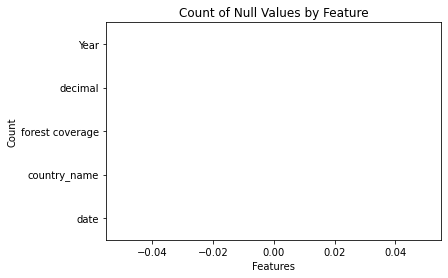

In [17]:
# Null values: count of missing by feature
missing_counts = global_forest_df.isna().sum().sort_values(ascending=True)
print(missing_counts)
missing_counts.plot(kind='barh')

plt.title('Count of Null Values by Feature')
plt.ylabel('Count')
plt.xlabel('Features')
plt.show()

Dataset #2 | Population

In [18]:
population = pd.read_csv("population_by_sex_residence.csv", index_col = 0)
population.head()

,Year,Area,Sex,Record Type,Reliability,Source Year,Value,Value Footnotes
Country or Area,,,,,,,,
Afghanistan,2020,Total,Both Sexes,Estimate - de facto,"Final figure, incomplete/questionable reliability",2021.0,31390171.0,1
Afghanistan,2019,Total,Both Sexes,Estimate - de facto,"Final figure, incomplete/questionable reliability",2019.0,30725560.0,1
Afghanistan,2018,Total,Both Sexes,Estimate - de facto,"Final figure, incomplete/questionable reliability",2019.0,30075018.0,1
Afghanistan,2017,Total,Both Sexes,Estimate - de facto,"Final figure, incomplete/questionable reliability",2018.0,28224323.0,1
Afghanistan,2016,Total,Both Sexes,Estimate - de facto,"Final figure, incomplete/questionable reliability",2017.0,27657145.0,1


In [19]:
population.columns
population.reset_index(inplace=True)
population.columns
population.head()

,Country or Area,Year,Area,Sex,Record Type,Reliability,Source Year,Value,Value Footnotes
0,Afghanistan,2020,Total,Both Sexes,Estimate - de facto,"Final figure, incomplete/questionable reliability",2021.0,31390171.0,1
1,Afghanistan,2019,Total,Both Sexes,Estimate - de facto,"Final figure, incomplete/questionable reliability",2019.0,30725560.0,1
2,Afghanistan,2018,Total,Both Sexes,Estimate - de facto,"Final figure, incomplete/questionable reliability",2019.0,30075018.0,1
3,Afghanistan,2017,Total,Both Sexes,Estimate - de facto,"Final figure, incomplete/questionable reliability",2018.0,28224323.0,1
4,Afghanistan,2016,Total,Both Sexes,Estimate - de facto,"Final figure, incomplete/questionable reliability",2017.0,27657145.0,1


In [20]:
population.duplicated().sum()

2

In [21]:
population = population.filter(items=['Country or Area','Year','Reliability','Value']).loc[(population['Reliability']=='Final figure, complete')]
population['Year'] = population['Year'].astype(int)
population = population.loc[(population['Year']>=2000) & (population['Year']<2020)]
population=population.rename(columns={'Value':'population value'})
population.head()

,Country or Area,Year,Reliability,population value
22,Åland Islands,2019,"Final figure, complete",29836.5
23,Åland Islands,2018,"Final figure, complete",29638.0
24,Åland Islands,2017,"Final figure, complete",29352.0
25,Åland Islands,2016,"Final figure, complete",29099.0
26,Åland Islands,2015,"Final figure, complete",28950.0


In [22]:
population = population.groupby(['Year', 'Country or Area']).mean('population value')


population.reset_index(inplace=True)
population.columns
population.head()

,Year,Country or Area,population value
0,2000,Albania,3.060908e+06
1,2000,American Samoa,5.749550e+04
2,2000,Andorra,6.586533e+04
3,2000,Anguilla,1.125400e+04
4,2000,Antigua and Barbuda,7.231000e+04


In [23]:
population.to_csv("populationWithContinent.csv")

First merged DataFrame | Population & Forest coverage on 'valid' countries 

In [24]:
merged_df_1 = pd.merge(population, global_forest_df, left_on=['Country or Area','Year'], right_on=['country_name', 'Year'], how='inner')
print(merged_df_1.shape)
merged_df_1.head()

(2112, 7)


,Year,Country or Area,population value,date,country_name,forest coverage,decimal
0,2000,Albania,3.060908e+06,2000,Albania,28.076642,1
1,2000,American Samoa,5.749550e+04,2000,American Samoa,88.650000,1
2,2000,Andorra,6.586533e+04,2000,Andorra,34.042553,1
3,2000,Antigua and Barbuda,7.231000e+04,2000,Antigua and Barbuda,21.477273,1
4,2000,Argentina,3.678386e+07,2000,Argentina,12.196486,1


In [25]:
merged_df_1.to_csv("merged_df_1.csv")

In [26]:
counts = merged_df_1['country_name'].value_counts()
valid_countries = counts[counts >= 20].index.tolist()

merged_df_1_filtered = merged_df_1[merged_df_1['country_name'].isin(valid_countries)]


merged_df_1_filtered.head()

,Year,Country or Area,population value,date,country_name,forest coverage,decimal
0,2000,Albania,3.060908e+06,2000,Albania,28.076642,1
1,2000,American Samoa,5.749550e+04,2000,American Samoa,88.650000,1
2,2000,Andorra,6.586533e+04,2000,Andorra,34.042553,1
3,2000,Antigua and Barbuda,7.231000e+04,2000,Antigua and Barbuda,21.477273,1
4,2000,Argentina,3.678386e+07,2000,Argentina,12.196486,1


In [27]:
merged_df_1_filtered.to_csv("merged_filtered.csv")

Dataset #3 | Food production

In [28]:
food = pd.read_csv("food_production.csv", index_col = 0)
food.head()

C:\Users\bogla_d7nsnlv\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
Area Code,,,,,,,,,,,,
2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1975,1975,ha,0.0,E
2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1976,1976,ha,5900.0,E
2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1977,1977,ha,6000.0,E
2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1978,1978,ha,6000.0,E
2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,1979,1979,ha,6000.0,E


In [29]:
food.duplicated().sum()

0

Filtering on a unit and dates

In [30]:
filtered_food= food.filter(items=['Area','Item','Element','Year','Unit','Value','Flag']).loc[(food['Flag']=='A')& (food['Element']=='Area harvested') & (food['Year']>=2000) & (food['Year']<2020)]
food_summary=filtered_food.groupby(['Year', 'Area']).sum('Value')
food_summary.reset_index(inplace=True)
food_summary=food_summary.rename(columns={'Value':'Area harvested'})
food_summary.head()


,Year,Area,Area harvested
0,2000,Afghanistan,4859700.0
1,2000,Africa,92961646.0
2,2000,Albania,461394.0
3,2000,Algeria,2845476.0
4,2000,Americas,350063825.0


In [31]:
food_summary.to_csv("food.csv")

Creating the final DataFrame

In [32]:
final_df = pd.merge(merged_df_1_filtered, food_summary, left_on=['country_name','Year'], right_on=['Area', 'Year'], how='inner')
print(final_df.shape)
final_df.head()

(1277, 9)


,Year,Country or Area,population value,date,country_name,forest coverage,decimal,Area,Area harvested
0,2000,Albania,3060907.5,2000,Albania,28.076642,1,Albania,461394.0
1,2000,Argentina,36783859.0,2000,Argentina,12.196486,1,Argentina,35446241.0
2,2000,Armenia,3221107.0,2000,Armenia,11.683878,1,Armenia,495584.0
3,2000,Australia,19153380.0,2000,Australia,17.158156,1,Australia,41834347.0
4,2000,Austria,8011566.0,2000,Austria,46.511634,1,Austria,2067205.0


In [33]:
final_df= final_df.filter(items=['Year','country_name','population value','forest coverage','Area harvested', ])

print(final_df.shape)
final_df.head()

(1277, 5)


,Year,country_name,population value,forest coverage,Area harvested
0,2000,Albania,3060907.5,28.076642,461394.0
1,2000,Argentina,36783859.0,12.196486,35446241.0
2,2000,Armenia,3221107.0,11.683878,495584.0
3,2000,Australia,19153380.0,17.158156,41834347.0
4,2000,Austria,8011566.0,46.511634,2067205.0


In [34]:
final_df.to_csv("final_df.csv")

In [35]:
counts = final_df['country_name'].value_counts()
valid_countries = counts[counts >= 20].index.tolist()

final_df_filtered = final_df[final_df['country_name'].isin(valid_countries)]


final_df_filtered.head()

,Year,country_name,population value,forest coverage,Area harvested
0,2000,Albania,3060907.5,28.076642,461394.0
1,2000,Argentina,36783859.0,12.196486,35446241.0
2,2000,Armenia,3221107.0,11.683878,495584.0
3,2000,Australia,19153380.0,17.158156,41834347.0
4,2000,Austria,8011566.0,46.511634,2067205.0


In [36]:
final_df_filtered.to_csv("final_df_filtered.csv")

In [37]:
final_df_filtered['continent'] = final_df_filtered['country_name'].map(country_name_to_continent)

final_df_filtered.head()

<ipython-input-37-5b915f5c098c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_filtered['continent'] = final_df_filtered['country_name'].map(country_name_to_continent)


,Year,country_name,population value,forest coverage,Area harvested,continent
0,2000,Albania,3060907.5,28.076642,461394.0,Europe
1,2000,Argentina,36783859.0,12.196486,35446241.0,South America
2,2000,Armenia,3221107.0,11.683878,495584.0,Asia
3,2000,Australia,19153380.0,17.158156,41834347.0,Oceania
4,2000,Austria,8011566.0,46.511634,2067205.0,Europe


In [38]:
final_df_filtered.shape
final_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1180 entries, 0 to 1276
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              1180 non-null   int64  
 1   country_name      1180 non-null   object 
 2   population value  1180 non-null   float64
 3   forest coverage   1180 non-null   float64
 4   Area harvested    1180 non-null   float64
 5   continent         1180 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 64.5+ KB


In [39]:
final_df_filtered.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,1180.0,2.009500e+03,5.768726e+00,2000.000000,2.004750e+03,2.009500e+03,2.014250e+03,2.019000e+03
population value,1180.0,1.556264e+07,2.256422e+07,259380.000000,2.968712e+06,7.114853e+06,1.723194e+07,1.280637e+08
forest coverage,1180.0,3.233181e+01,2.180763e+01,0.297556,1.465116e+01,3.105156e+01,4.010455e+01,9.833891e+01
Area harvested,1180.0,6.711950e+06,1.178899e+07,1019.000000,4.900408e+05,1.787772e+06,4.928718e+06,5.089988e+07


In [40]:
final_df_filtered.to_csv("final_df_filtered_continents.csv")

In [41]:
selected_countries = ['Japan', 'Germany', 'Italy', 'Spain', 'France', 'Ukraine', 'Argentina']  

selected_countries_df = final_df_filtered[final_df_filtered['country_name'].isin(selected_countries)]
selected_countries_df.info()
selected_countries_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 1 to 1274
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              140 non-null    int64  
 1   country_name      140 non-null    object 
 2   population value  140 non-null    float64
 3   forest coverage   140 non-null    float64
 4   Area harvested    140 non-null    float64
 5   continent         140 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 7.7+ KB


,Year,country_name,population value,forest coverage,Area harvested,continent
1,2000,Argentina,36783859.0,12.196486,35446241.0,South America
22,2000,France,59144034.0,27.919871,25022565.0,Europe
24,2000,Germany,82187614.0,32.537613,17221998.0,Europe
32,2000,Italy,57311001.5,28.301456,14935592.0,Europe
34,2000,Japan,126233869.0,68.246914,6249231.0,Asia


In [42]:
selected_countries_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,140.0,2.009500e+03,5.786986e+00,2.000000e+03,2.004750e+03,2.009500e+03,2.014250e+03,2.019000e+03
population value,140.0,6.597378e+07,2.833268e+07,3.670816e+07,4.549540e+07,5.909600e+07,8.152094e+07,1.280637e+08
forest coverage,140.0,3.217577e+01,1.708050e+01,1.048018e+01,1.666100e+01,3.097595e+01,3.548135e+01,6.849383e+01
Area harvested,140.0,2.308784e+07,1.326571e+07,1.863870e+06,1.444195e+07,2.168156e+07,3.556795e+07,5.089988e+07


In [43]:
selected_countries_df.to_csv("selected_countries_df.csv")

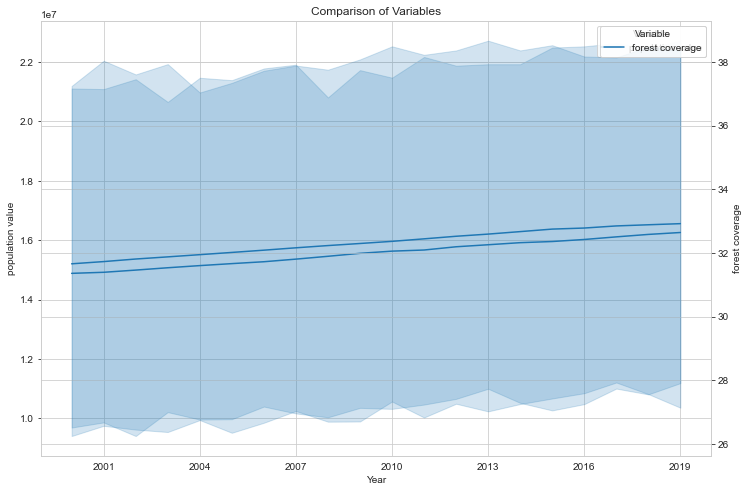

In [44]:
# Specify the columns to include in the line plot
columns_to_plot = ['population value', 'forest coverage', 'Area harvested']

# Filter the DataFrame to include only the specified columns
df_filtered = final_df_filtered[['Year'] + columns_to_plot]

# Melt the DataFrame to transform it into a long format
df_long = df_filtered.melt('Year', var_name='Variable', value_name='Value')

# Convert 'Value' column to numeric data type
df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

plt.figure(figsize=(12, 8))

# Create a line plot for Variable1 using the primary y-axis
sns.set_style('whitegrid')
ax1 = sns.lineplot(data=df_long[df_long['Variable'] == 'population value'], x='Year', y='Value', hue='Variable')

# Create a secondary y-axis for Variable2
ax2 = ax1.twinx()
sns.lineplot(data=df_long[df_long['Variable'] == 'forest coverage'], x='Year', y='Value', hue='Variable', ax=ax2)

# Set the plot title and labels
plt.title('Comparison of Variables')
ax1.set_xlabel('Year')
ax1.set_ylabel('population value')
ax2.set_ylabel('forest coverage')

# Format x-axis tick labels as integers
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Show the plot
plt.show()

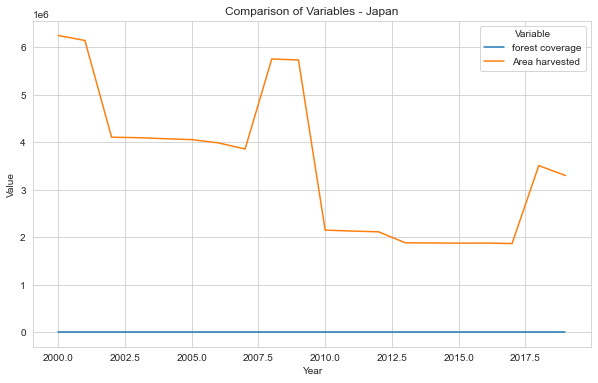

In [45]:
# Filter the DataFrame for data from a specific country
country_of_interest = 'Japan'
df_filtered_Japan = final_df_filtered.loc[final_df_filtered['country_name'] == country_of_interest]

# Specify the columns to include in the line plot
columns_to_plot = ['forest coverage', 'Area harvested']

# Filter the DataFrame to include only the specified columns
df_Japan_filtered = df_filtered_Japan[['Year'] + columns_to_plot]


# Melt the DataFrame to transform it into a long format
df_long_Japan = df_Japan_filtered.melt('Year', var_name='Variable', value_name='Value')

# Convert 'Value' column to numeric data type
df_long_Japan['Value'] = pd.to_numeric(df_long_Japan['Value'], errors='coerce')

plt.figure(figsize=(10, 6))

# Create a line plot using seaborn
sns.set_style('whitegrid')
sns.lineplot(data=df_long_Japan, x='Year', y='Value', hue='Variable')

# Set the plot title and labels
plt.title(f"Comparison of Variables - {country_of_interest}")
plt.xlabel('Year')
plt.ylabel('Value')



# Show the plot
plt.show()

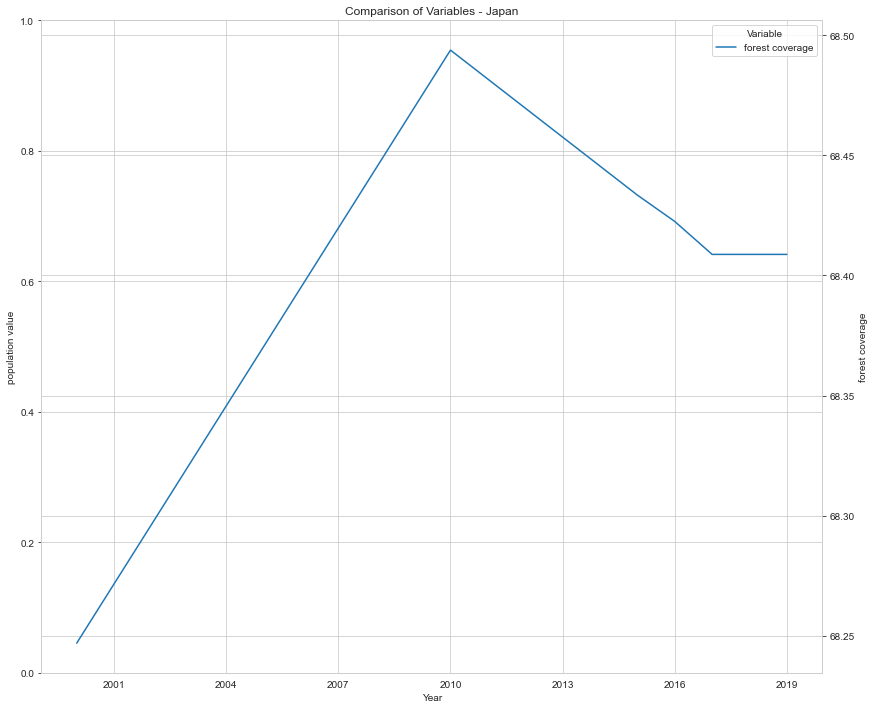

In [46]:
# Filter the DataFrame for data from a specific country
country_of_interest = 'Japan'
df_filtered_Japan = final_df_filtered.loc[final_df_filtered['country_name'] == country_of_interest]


# Specify the columns to include in the line plot
columns_to_plot = ['forest coverage']

# Filter the DataFrame to include only the specified columns
df_Japan_filtered = df_filtered_Japan[['Year'] + columns_to_plot]


# Melt the DataFrame to transform it into a long format
df_long_Japan = df_Japan_filtered.melt('Year', var_name='Variable', value_name='Value')

# Convert 'Value' column to numeric data type
df_long_Japan['Value'] = pd.to_numeric(df_long_Japan['Value'], errors='coerce')

plt.figure(figsize=(14, 12))


# Create a line plot for Variable1 using the primary y-axis
sns.set_style('whitegrid')
ax1 = sns.lineplot(data=df_long_Japan[df_long_Japan['Variable'] == 'population value'], x='Year', y='Value', hue='Variable')

# Create a secondary y-axis for Variable2
ax2 = ax1.twinx()
sns.lineplot(data=df_long_Japan[df_long_Japan['Variable'] == 'forest coverage'], x='Year', y='Value', hue='Variable', ax=ax2)

# Set the plot title and labels
plt.title(f"Comparison of Variables - {country_of_interest}")
ax1.set_xlabel('Year')
ax1.set_ylabel('population value')
ax2.set_ylabel('forest coverage')

# Format x-axis tick labels as integers
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Show the plot
plt.show()

Linear regression

Independent Variable (x axis) 
Known as the predictor or explanatory variable, is a variable that is hypothesized to have an influence on the dependent variable. It is the variable that is manipulated or controlled by the analyst. In a linear regression model, independent variables are used to estimate or predict the value of the dependent variable (y axis).

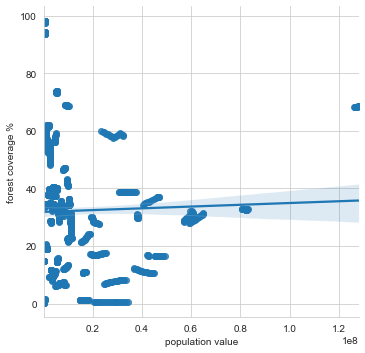

In [47]:
sns.lmplot(x='population value',y='forest coverage',data = final_df_filtered)

plt.xlabel('population value')
plt.ylabel('forest coverage %')

plt.show()

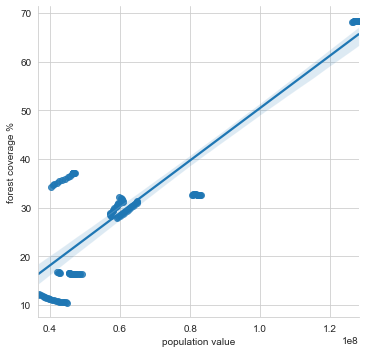

In [48]:
sns.lmplot(x='population value',y='forest coverage',data = selected_countries_df)

plt.xlabel('population value')
plt.ylabel('forest coverage %')

plt.show()

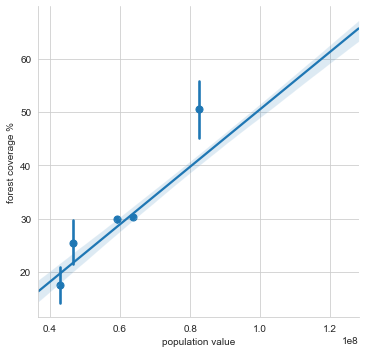

In [49]:
sns.lmplot(x='population value',y='forest coverage',data = selected_countries_df,x_bins=5)

plt.xlabel('population value')
plt.ylabel('forest coverage %')

plt.show()

Bootstrapping - the average data in the bucket

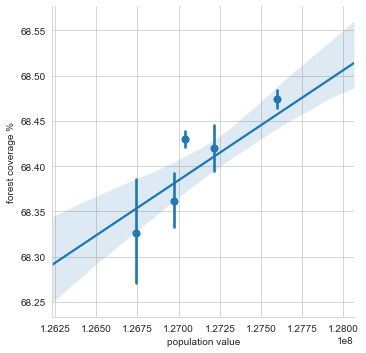

In [50]:
sns.lmplot(x='population value',y='forest coverage',data = final_df_filtered[final_df_filtered.country_name=='Japan'],x_bins=5)
plt.xlabel('population value')
plt.ylabel('forest coverage %')

plt.show()

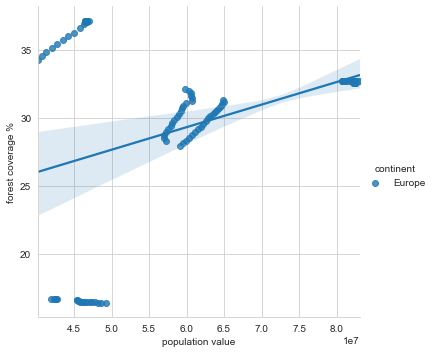

In [51]:
sns.lmplot(x='population value',y='forest coverage',hue='continent' , data = selected_countries_df[selected_countries_df.continent=='Europe'])
plt.xlabel('population value')
plt.ylabel('forest coverage %')

plt.show()

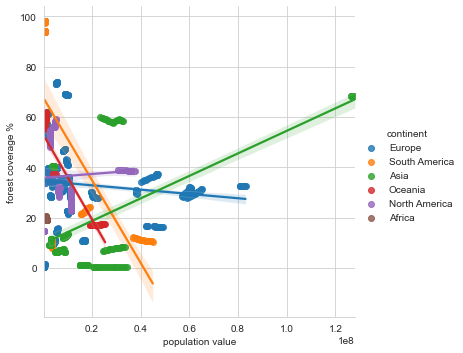

In [52]:
sns.lmplot(x='population value',y='forest coverage',hue='continent' , data = final_df_filtered)
plt.xlabel('population value')
plt.ylabel('forest coverage %')

plt.show()

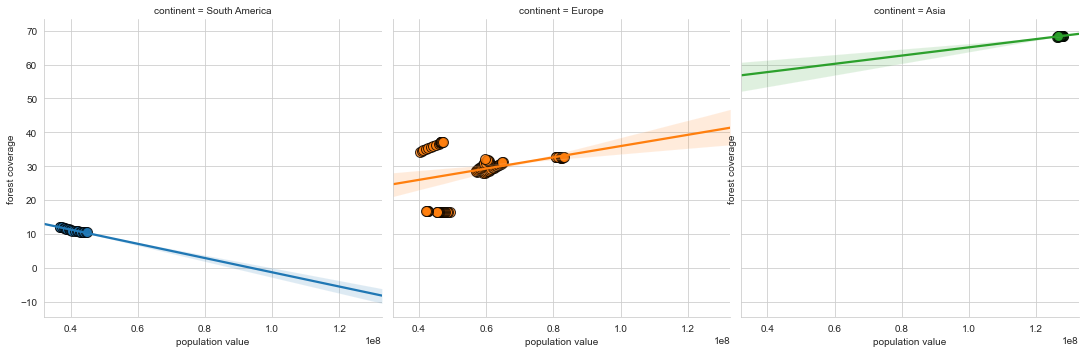

In [53]:
sns.lmplot(x='population value',y='forest coverage',hue='continent',col= 'continent', scatter_kws={'s':100, 'edgecolor':'black'},truncate= False, data = selected_countries_df)
plt.xlabel('population value')
plt.ylabel('forest coverage')

plt.show()

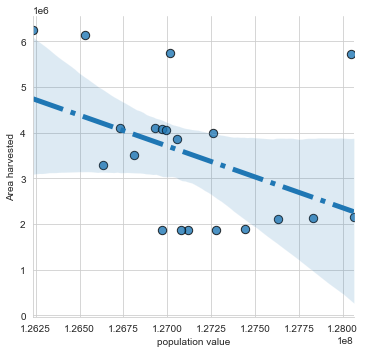

In [54]:
sns.lmplot(x='population value',y='Area harvested', scatter_kws={'s':70, 'edgecolor':'black'}, line_kws={'lw':5, 'ls':'-.'},data = final_df_filtered[final_df_filtered.country_name=='Japan'])
plt.xlabel('population value')
plt.ylabel('Area harvested')

plt.show()

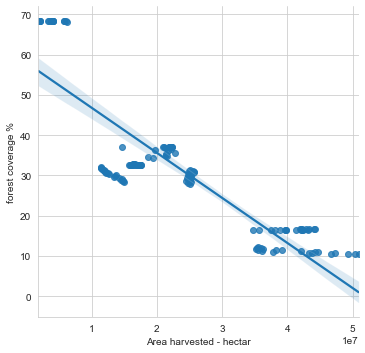

In [55]:
sns.lmplot(x='Area harvested',y='forest coverage',data = selected_countries_df)
plt.xlabel('Area harvested - hectar')
plt.ylabel('forest coverage %')

plt.show()

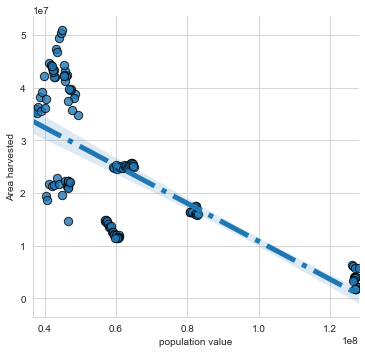

In [56]:
sns.lmplot(x='population value',y='Area harvested', scatter_kws={'s':70, 'edgecolor':'black'}, line_kws={'lw':5, 'ls':'-.'},data = selected_countries_df)
plt.xlabel('population value')
plt.ylabel('Area harvested')

plt.show()

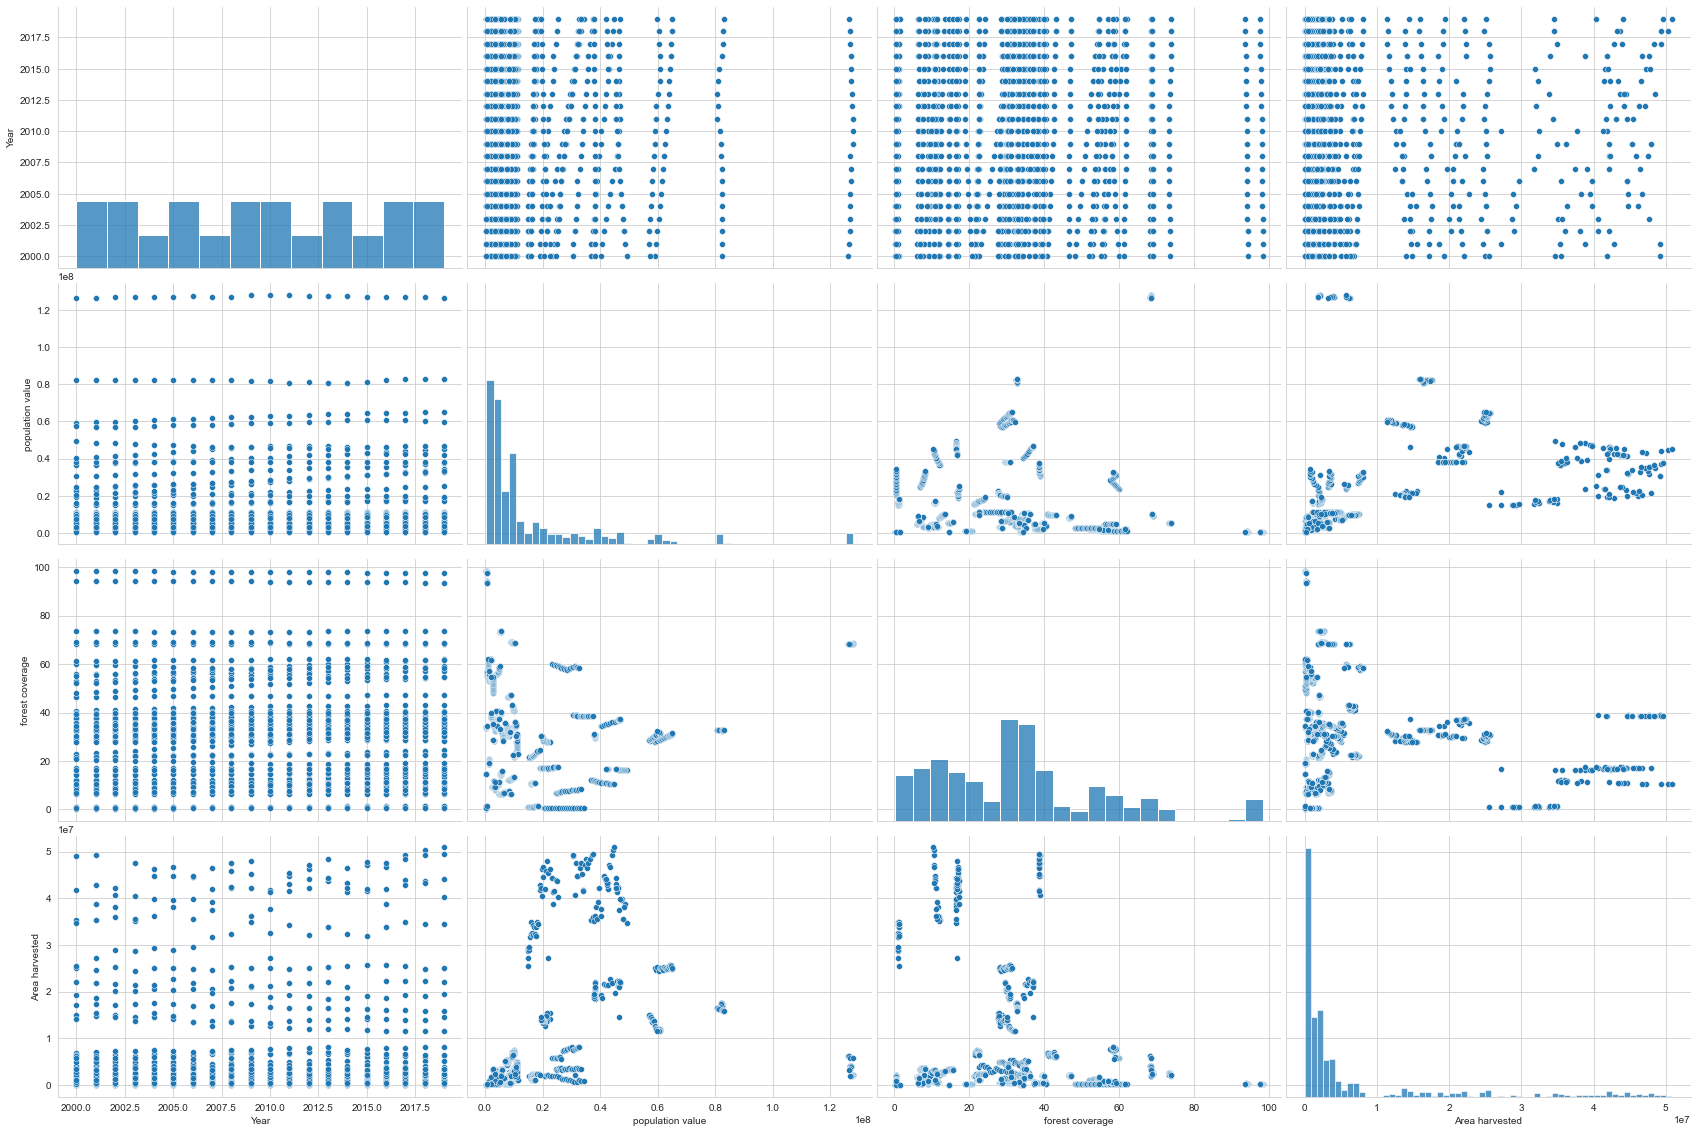

In [57]:
columns_of_interest = ['population value', 'forest coverage', 'Area harvested']

sns.pairplot(final_df_filtered, height=4, aspect=1.5,)
plt.show()

In [58]:
df_stats = pd.read_csv('selected_countries_df.csv')  


X = df_stats['population value']
y = df_stats['forest coverage']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        forest coverage   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     555.1
Date:                Wed, 17 May 2023   Prob (F-statistic):           3.27e-50
Time:                        15:23:50   Log-Likelihood:                -482.48
No. Observations:                 140   AIC:                             969.0
Df Residuals:                     138   BIC:                             974.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.4179      1.643  

In [59]:
df_stats = pd.read_csv('selected_countries_df.csv')  


X = df_stats['forest coverage']
y = df_stats['Area harvested']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Area harvested   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     429.5
Date:                Wed, 17 May 2023   Prob (F-statistic):           3.31e-44
Time:                        15:23:50   Log-Likelihood:                -2395.3
No. Observations:                 140   AIC:                             4795.
Df Residuals:                     138   BIC:                             4800.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.483e+07   1.19e+06     

In [60]:
# correlation matrix
df_corr = selected_countries_df[columns_of_interest].corr()
df_corr

,population value,forest coverage,Area harvested
population value,1.000000,0.894930,-0.767816
forest coverage,0.894930,1.000000,-0.869955
Area harvested,-0.767816,-0.869955,1.000000


In [61]:
df_corr_59 = final_df_filtered[columns_of_interest].corr()
df_corr_59

,population value,forest coverage,Area harvested
population value,1.000000,0.031831,0.474590
forest coverage,0.031831,1.000000,-0.180607
Area harvested,0.474590,-0.180607,1.000000


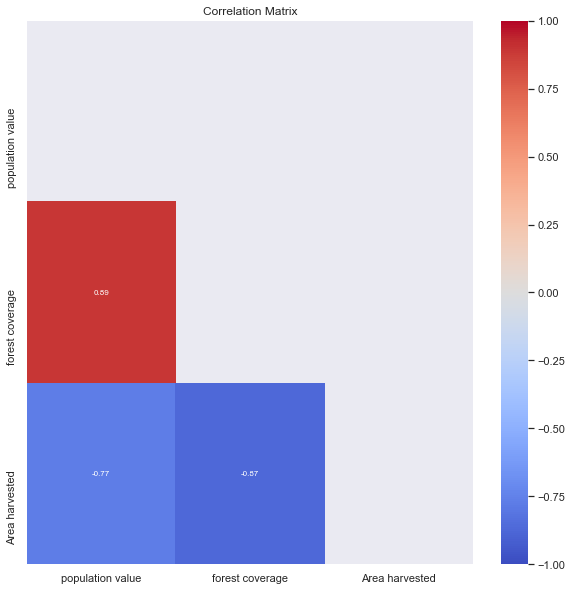

In [62]:
# Plot the correlation matrix of the dataset

# Create a mask upper triangle
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)]= True

sns.set(font_scale=1.0)
plt.figure(figsize=(10,10))
sns.heatmap(
    df_corr, 
    annot=True, 
    annot_kws={'size': 8}, 
    cmap='coolwarm', 
    cbar=True, 
    vmin=-1, 
    vmax=1, 
    mask=mask
    )

# Show the plot
plt.title('Correlation Matrix')
plt.show()

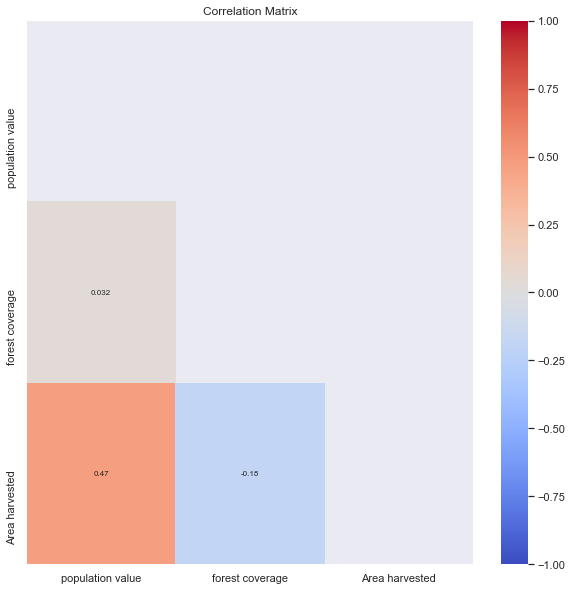

In [63]:
# Plot the correlation matrix of the dataset

# Create a mask upper triangle
mask = np.zeros_like(df_corr_59, dtype=bool)
mask[np.triu_indices_from(mask)]= True

sns.set(font_scale=1.0)
plt.figure(figsize=(10,10))
sns.heatmap(
    df_corr_59, 
    annot=True, 
    annot_kws={'size': 8}, 
    cmap='coolwarm', 
    cbar=True, 
    vmin=-1, 
    vmax=1, 
    mask=mask
    )

# Show the plot
plt.title('Correlation Matrix')
plt.show()

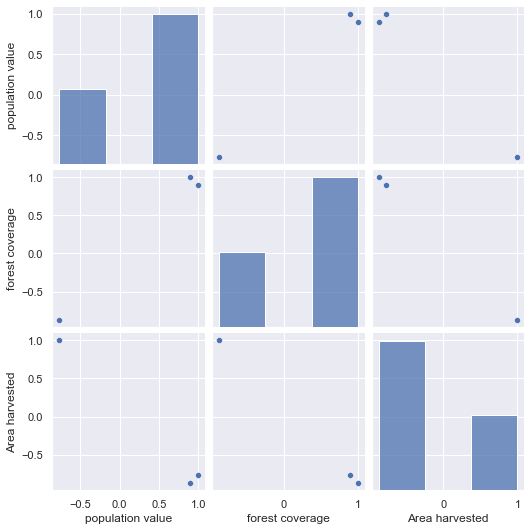

In [64]:
sns.pairplot(df_corr)

In [132]:
# y is the target variable, it represents the variable I want to predict

X = selected_countries_df[['Area harvested', 'forest coverage', 'Year']]
y = selected_countries_df['population value']

In [133]:
# splitting the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

In [134]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (140, 3)
y shape: (140,)


In [135]:
# Initialize and fit a linear regression model

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [136]:
# Predict the target variable using the test set

y_pred = model.predict(X_test)

In [137]:
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 223094181277181.5


In [139]:
# Predictions on new data

new_data = pd.DataFrame({'forest coverage': [48], 'Year': [2100], 'Area Hharvested': [100000]})
prediction = model.predict(new_data)
print('Prediction:', prediction)

Prediction: [1.19934824e+10]
